

# **Comparative Evaluation of Language Models (LLMs) within Dialog Agent**



# **General description of the code :**
This code performs several tasks related to training and evaluating language models, specifically GPT-2 and T5, using the DialoGPT and T5 models from the Hugging Face Transformers library. Here's a general description of the code:

1. Model Initialization:
*   It initializes the tokenizer and model for both GPT-2

(DialoGPT-small) and T5 (t5-small).
2. Dataset Loading and Preprocessing:
*  Loads a persona-based chat dataset using the Hugging Face datasets library.
*  Concatenates all utterances within each dialogue and maps them to the 'dialog' key in the dataset.
*  Encodes the dataset for both GPT-2 and T5 models, adding padding and truncation as necessary.
3. Training Configuration:
*  Defines training arguments for both GPT-2 and T5 models, including output directory, number of training epochs, weight decay, and logging settings.
4. Training:
*  Trains the GPT-2 model using the Trainer class from the Transformers library.
*  Trains the T5 model using the same Trainer class.
5. System Usage Monitoring:
*  Collects and plots CPU and memory usage over time during training for both models.
*  The system usage data is collected using the psutil library.
6. Evaluation:
*  Evaluates the trained models using various evaluation metrics.
*  Calculates BLEU scores for both GPT-2 and T5 models by generating responses and comparing them with reference texts from the dataset.
*  Calculates distinct metrics (DIST-1 and DIST-2) for both models, which measure the diversity of generated responses.
7. Visualization:
*  Visualizes self-attention patterns for both GPT-2 and T5 models.
*  The attention visualization function plots self-attention matrices for a given input text.

Overall, this code provides a comprehensive pipeline for training, evaluating, and visualizing language models, focusing on GPT-2 and T5 architectures, using a persona-based chat dataset. It also includes monitoring of system resource usage during training.




### **Type of system used for the code:**
We are not using GCP(Google cloud plateform) or GPU but we can use to make it faster.

In [ ]:
# !pip install -U transformers
# !pip install datasets
# !pip install -U accelerate

Dataset:--- Persona A: Hey! How is your day going?
validation_dataset:------- Dataset({
    features: ['conv_id', 'persona_b', 'dialogue', 'reference', 'dialog', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 6420
})


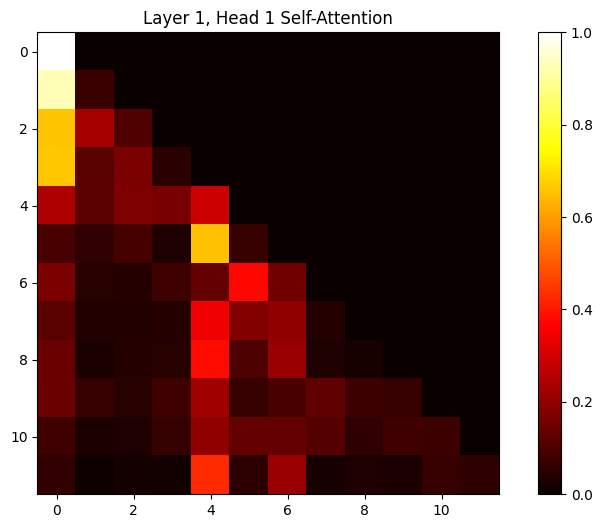

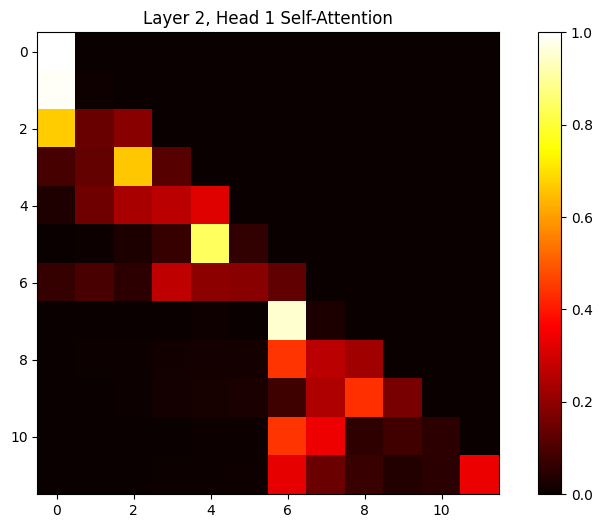

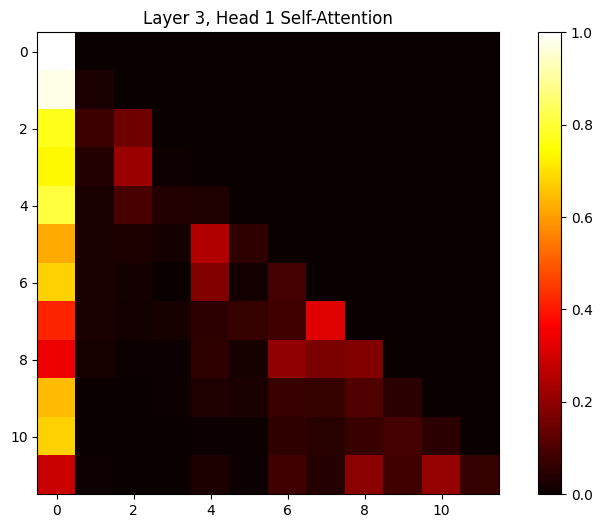

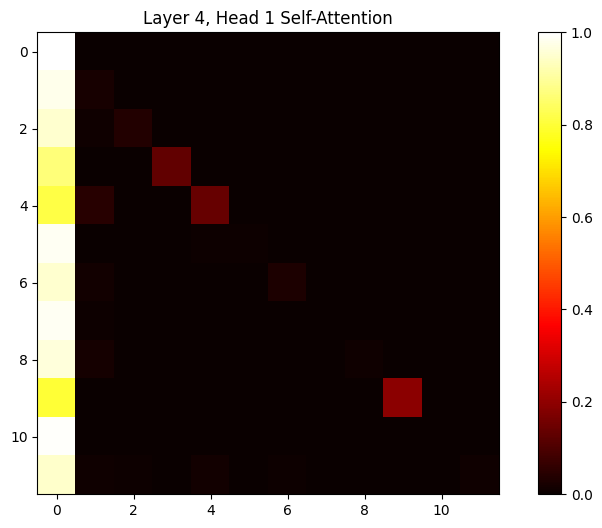

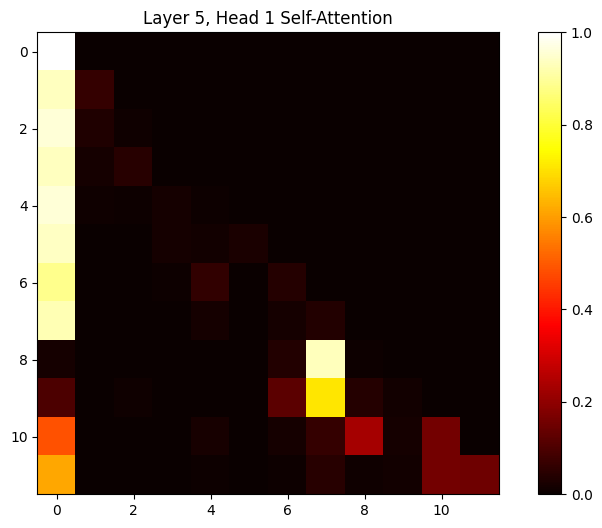

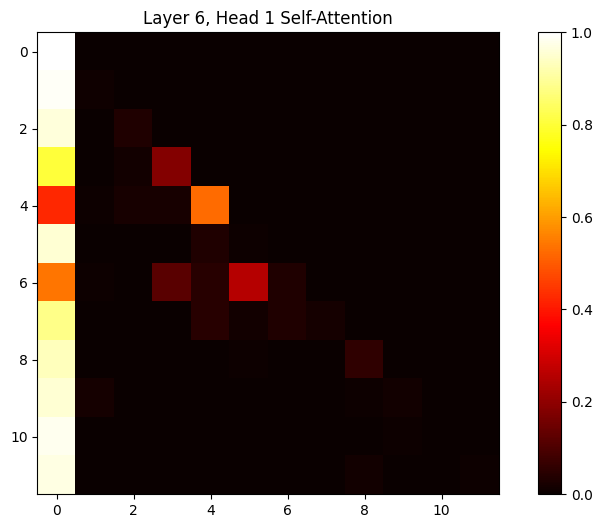

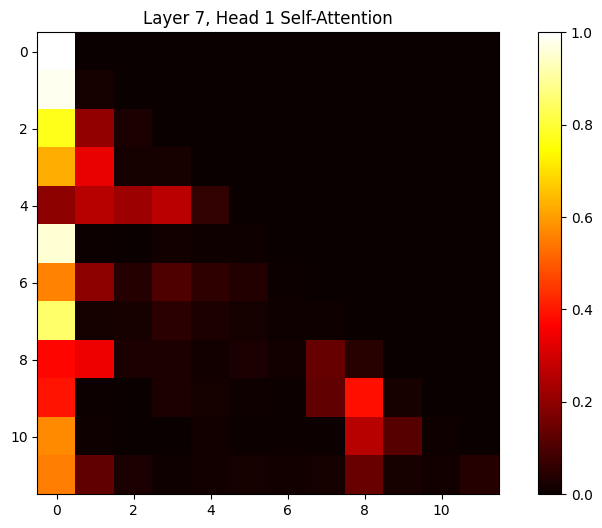

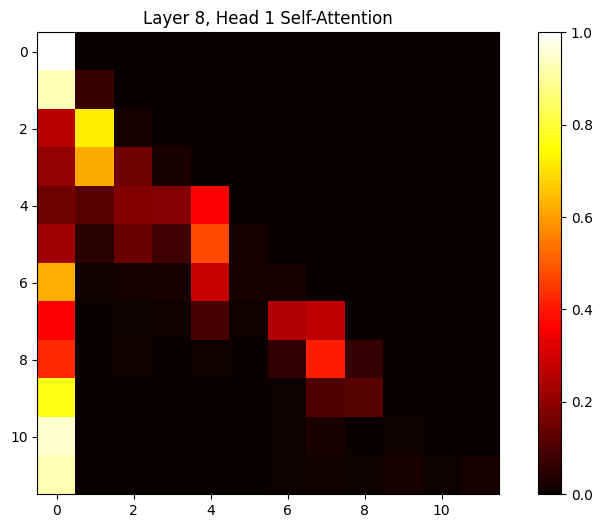

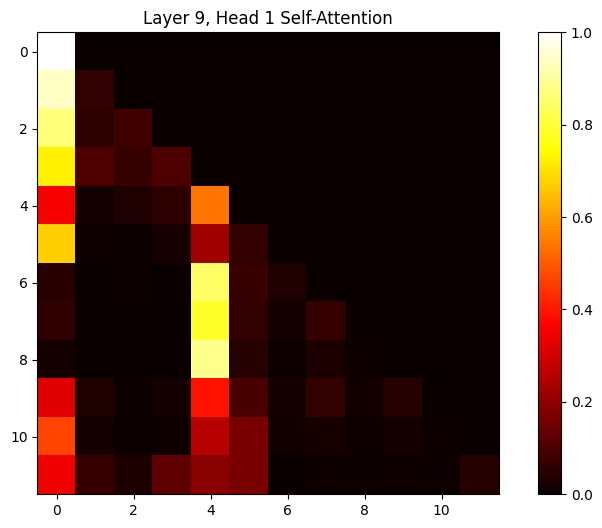

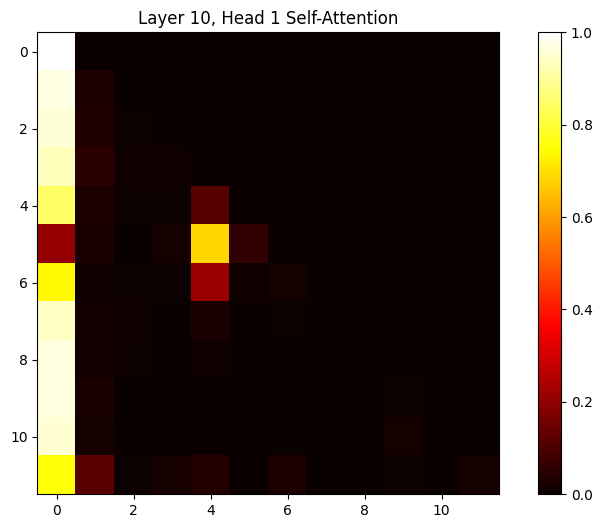

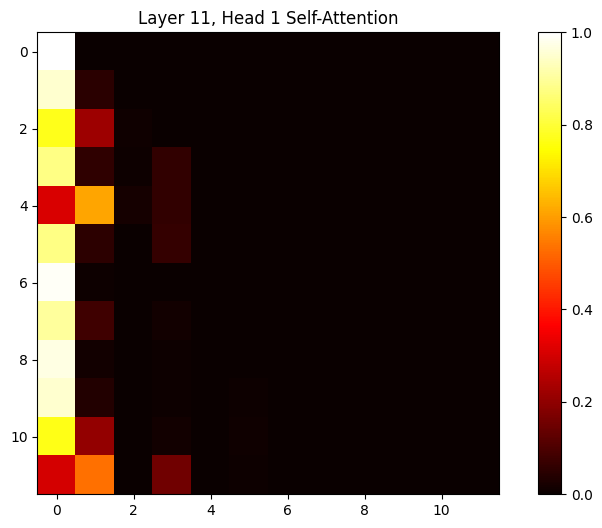

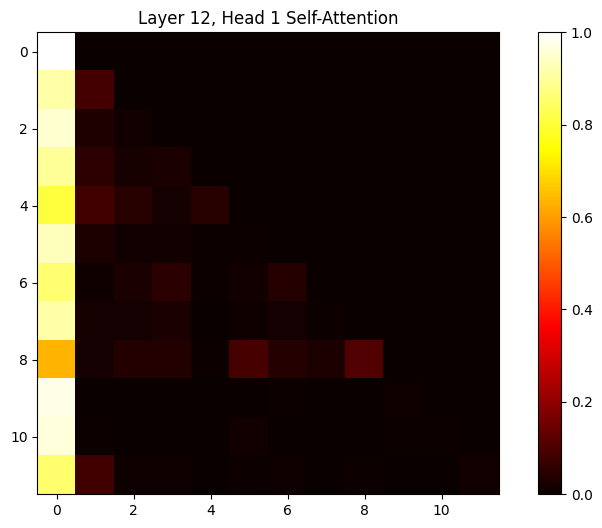

In [ ]:
import tempfile
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer
import matplotlib.pyplot as plt
from transformers import GPT2Model
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import psutil
from datetime import datetime
import time


# ----------Load the tokenizer and model DialoGPT-----------------------
tokenizer = GPT2Tokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = tokenizer.eos_token
model_gpt2 = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")


# ---------------Load dataset---------------------------------------
dataset = load_dataset("nazlicanto/persona-based-chat")
print("Dataset:---",dataset['train']["dialogue"][0][0])

# Concatenate all utterances within a dialogue and map to 'dialog' key
def concatenate_utterances(example):
    example['dialog'] = " ".join(example['dialogue'])  # Assuming 'dialogue' is the key containing individual utterances
    return example

# -----Apply the function to all examples in the dataset----------------------------------
dataset = dataset.map(concatenate_utterances)


# -----------------Encode the dataset-----------------------------------------------------
def encode(examples):
    encoded = tokenizer(examples['dialog'], truncation=True, padding='max_length', max_length=128)
    encoded['labels'] = encoded['input_ids'][:]  # Set labels to the same as input_ids for language modeling
    return encoded

encoded_dataset = dataset.map(encode, batched=True)

# ------------Split the dataset into training and validation-------------------------------
train_dataset = encoded_dataset['train'].train_test_split(test_size=0.1)['train']
validation_dataset = encoded_dataset['train'].train_test_split(test_size=0.1)['test']
print("validation_dataset:-------",validation_dataset)

# ----------------Attention visiblization---------------------------------------------------
# Define a function to visualize self-attention
def visualize_self_attention_gpt(input_text):
    # Tokenize input text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids

    # Forward pass through the model
    outputs = model_gpt2(input_ids, output_attentions=True)

    # Extract self-attention matrices
    attentions = outputs.attentions

    if attentions is None:
        print("Self-attention matrices not available.")
        return

    # Plot self-attention matrices
    for layer, layer_attentions in enumerate(attentions):
        for head, head_attentions in enumerate(layer_attentions):
            # Normalize attention scores for visualization
            attention_probs = head_attentions[0, :, :].detach().numpy()
            attention_probs = (attention_probs - attention_probs.min()) / (attention_probs.max() - attention_probs.min() + 1e-9)

            # Plot the attention matrix
            plt.figure(figsize=(10, 6))
            plt.imshow(attention_probs, cmap='hot', interpolation='nearest')
            plt.title(f"Layer {layer + 1}, Head {head + 1} Self-Attention")
            plt.colorbar()
            plt.show()



# Visualize self-attention for the input text
visualize_self_attention_gpt(dataset['train']["dialogue"][0][0])



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


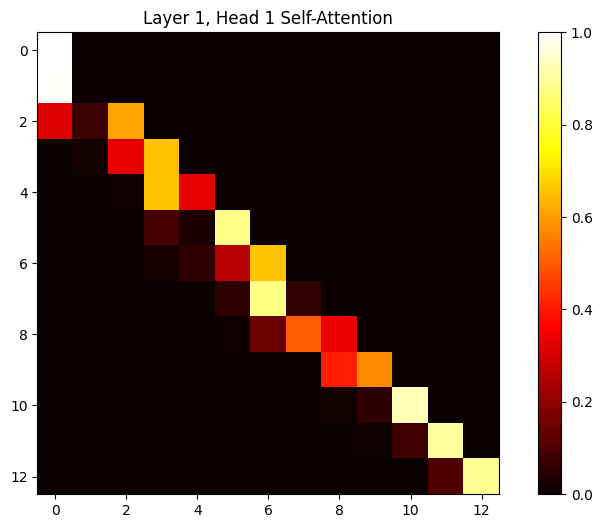

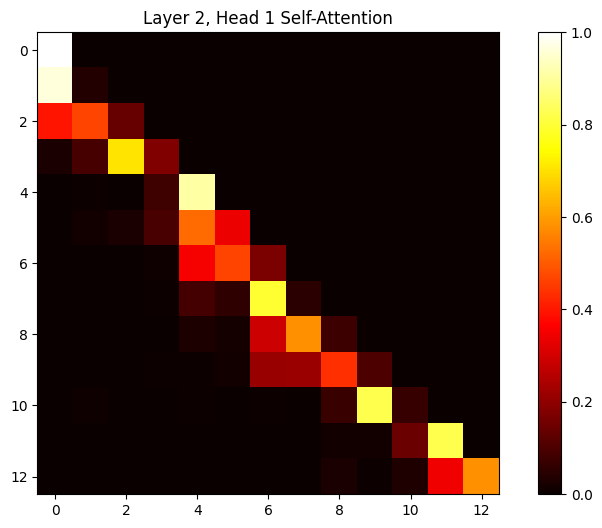

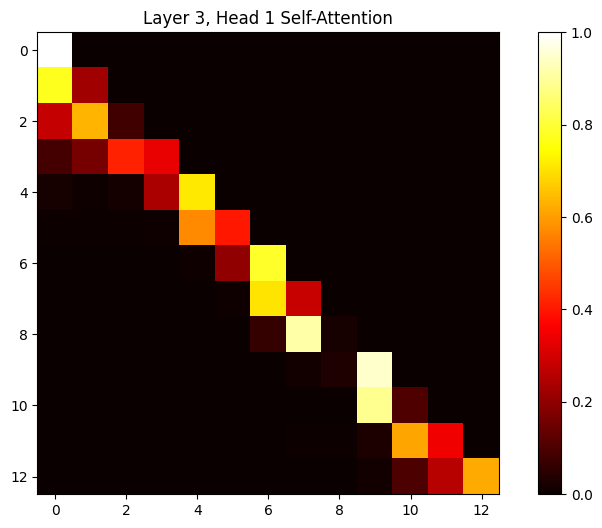

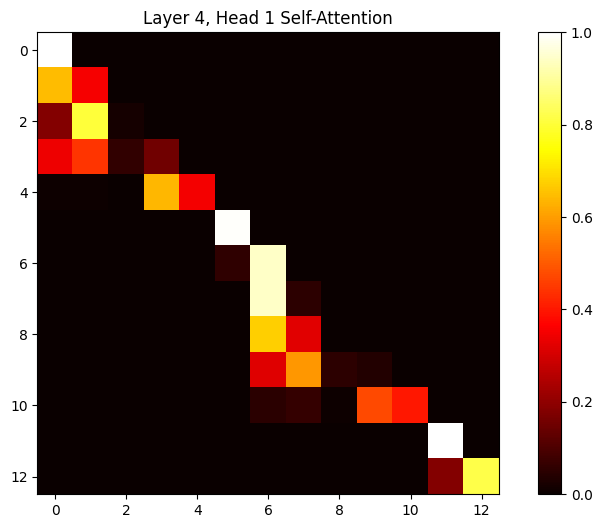

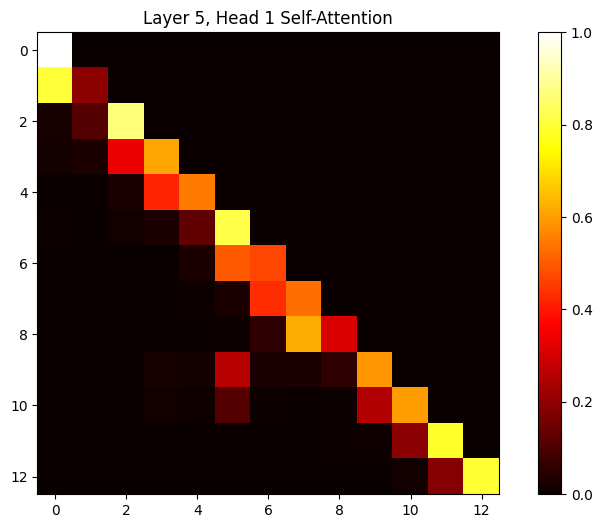

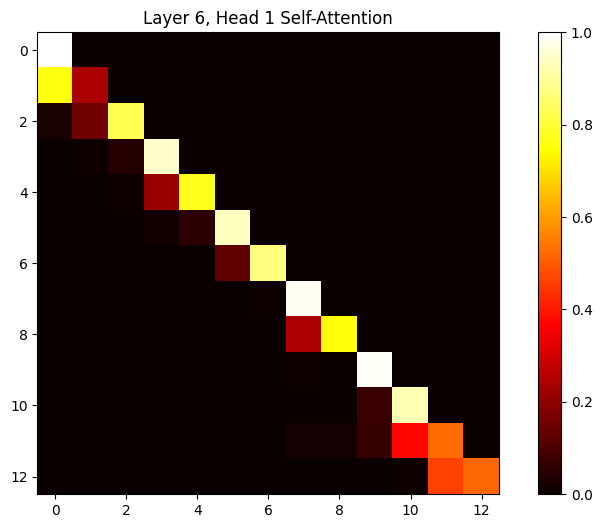

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

# ------------------------------T5 model------------------------------------------------

# Load the tokenizer and model
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-small")
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-small")


# Encode the dataset
def encode_t5(examples):
    inputs = tokenizer_t5(["chat: " + dialogue for dialogue in examples['dialog']], truncation=True, padding='max_length', max_length=128, return_tensors="pt")
    labels = tokenizer_t5([dialogue for dialogue in examples['dialog']], truncation=True, padding='max_length', max_length=128, return_tensors="pt")["input_ids"]
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': labels}

encoded_dataset_t5 = dataset.map(encode_t5, batched=True)

# Split the dataset into training and validation
train_dataset_t5 = encoded_dataset_t5['train'].train_test_split(test_size=0.1)['train']
validation_dataset_t5 = encoded_dataset_t5['train'].train_test_split(test_size=0.1)['test']

# ----------------T5 Self-Attention visiblization ---------------------------------------------
# Define a function to visualize self-attention
def visualize_self_attention(input_text):
    # Tokenize input text
    input_ids = tokenizer_t5(input_text, return_tensors="pt").input_ids

    # Forward pass through the model
    outputs = model_t5(input_ids, decoder_input_ids=input_ids, output_attentions=True)

    # Extract self-attention matrices
    attentions = outputs.decoder_attentions

    if attentions is None:
        print("Self-attention matrices not available.")
        return

    # Plot self-attention matrices
    for layer, layer_attentions in enumerate(attentions):
        for head, head_attentions in enumerate(layer_attentions):
            # Normalize attention scores for visualization
            attention_probs = head_attentions[0, :, :].detach().numpy()
            attention_probs = (attention_probs - attention_probs.min()) / (attention_probs.max() - attention_probs.min() + 1e-9)

            # Plot the attention matrix
            plt.figure(figsize=(10, 6))
            plt.imshow(attention_probs, cmap='hot', interpolation='nearest')
            plt.title(f"Layer {layer + 1}, Head {head + 1} Self-Attention")
            plt.colorbar()
            plt.show()



# Visualize self-attention for the input text
visualize_self_attention(dataset['train']["dialogue"][0][0])


In [ ]:

training_args_gpt2 = TrainingArguments(
    output_dir=tempfile.mkdtemp(),   # output directory
    num_train_epochs=0.1,               # total number of training epochs
    # per_device_train_batch_size=4,    # batch size per device during training
    # per_device_eval_batch_size=8,     # batch size for evaluation
    # warmup_steps=10,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir=None,                 # directory for storing logs
    logging_steps=100                  # log after each step
)

training_args_t5 = TrainingArguments(
    output_dir=tempfile.mkdtemp(),   # output directory
    num_train_epochs=0.01,               # total number of training epochs
    # per_device_train_batch_size=4,    # batch size per device during training
    # per_device_eval_batch_size=8,     # batch size for evaluation
    # warmup_steps=10,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir=None,                 # directory for storing logs
    logging_steps=100                   # log after each step
)

# Create Trainer for GPT-2
trainer_gpt2 = Trainer(
    model=model_gpt2,
    args=training_args_gpt2,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

# Create Trainer for T5
trainer_t5 = Trainer(
    model=model_t5,
    args=training_args_t5,
    train_dataset=train_dataset_t5,
    eval_dataset=validation_dataset
)

# -------------Train models GPT-------------------
trainer_gpt2.train()


# -----------GPT2 system usage------------------

# Function to collect system usage data
def collect_system_usage(interval, duration):
    timestamps = []
    cpu_percentages = []
    memory_percentages = []

    end_time = time.time() + duration
    while time.time() < end_time:
        # Get current timestamp
        timestamps.append(datetime.now())

        # Get CPU and memory usage
        cpu_percent = psutil.cpu_percent(interval=interval)
        memory_percent = psutil.virtual_memory().percent

        # Append to lists
        cpu_percentages.append(cpu_percent)
        memory_percentages.append(memory_percent)

        time.sleep(interval)

    return timestamps, cpu_percentages, memory_percentages

# Collect system usage data for 60 seconds with interval of 1 second
timestamps, cpu_percentages, memory_percentages = collect_system_usage(interval=1, duration=60)

# Plot CPU and memory usage over time
plt.figure(figsize=(10, 6))
plt.plot(timestamps, cpu_percentages, label='CPU Usage (%)', color='blue')
plt.plot(timestamps, memory_percentages, label='Memory Usage (%)', color='green')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.title('System Usage Over Time')
plt.legend()
plt.grid(True)
plt.show()
# ---------------------------------------------------------------

# ------------Training T5-----------------------------------------
trainer_t5.train()

# ------------T5 system usage------------------------------------

# Function to collect system usage data
def collect_system_usage(interval, duration):
    timestamps = []
    cpu_percentages = []
    memory_percentages = []

    end_time = time.time() + duration
    while time.time() < end_time:
        # Get current timestamp
        timestamps.append(datetime.now())

        # Get CPU and memory usage
        cpu_percent = psutil.cpu_percent(interval=interval)
        memory_percent = psutil.virtual_memory().percent

        # Append to lists
        cpu_percentages.append(cpu_percent)
        memory_percentages.append(memory_percent)

        time.sleep(interval)

    return timestamps, cpu_percentages, memory_percentages

# Collect system usage data for 60 seconds with interval of 1 second
timestamps, cpu_percentages, memory_percentages = collect_system_usage(interval=1, duration=60)

# Plot CPU and memory usage over time
plt.figure(figsize=(10, 6))
plt.plot(timestamps, cpu_percentages, label='CPU Usage (%)', color='blue')
plt.plot(timestamps, memory_percentages, label='Memory Usage (%)', color='green')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.title('System Usage Over Time')
plt.legend()
plt.grid(True)
plt.show()
# -----------------------------------------------------------



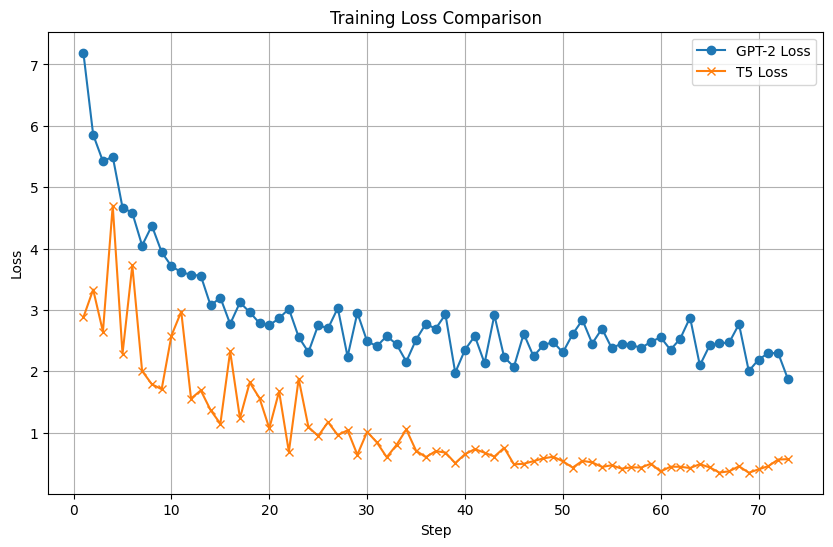

In [ ]:

# Extract training loss and epoch values from the log history
gpt2_train_loss_history = [item.get('loss', None) for item in trainer_gpt2.state.log_history if 'loss' in item]
gpt2_epochs = list(range(1, len(gpt2_train_loss_history) + 1))  # Generate epochs from 1 to the total number of training iterations


# Extract training loss values from the log history
t5_train_loss_history = [item.get('loss', None) for item in trainer_t5.state.log_history if 'loss' in item]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(gpt2_train_loss_history ) + 1), gpt2_train_loss_history , label='GPT-2 Loss', marker='o')
plt.plot(range(1, len(t5_train_loss_history) + 1), t5_train_loss_history, label='T5 Loss', marker='x')
plt.title('Training Loss Comparison')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

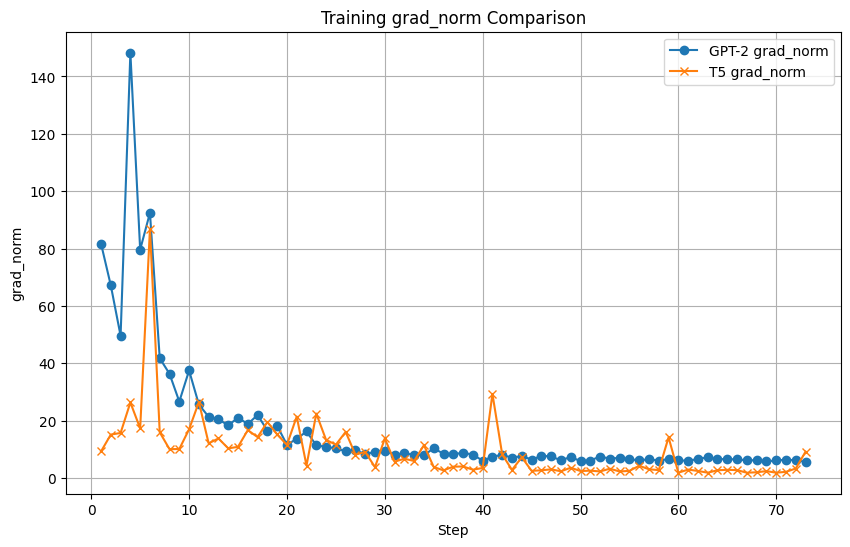

In [ ]:
# Extract loss values
gpt2_losses = [item.get('grad_norm', None) for item in trainer_gpt2.state.log_history if 'grad_norm' in item]
t5_losses = [item.get('grad_norm', None) for item in trainer_t5.state.log_history if 'grad_norm' in item]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(gpt2_losses) + 1), gpt2_losses, label='GPT-2 grad_norm', marker='o')
plt.plot(range(1, len(t5_losses) + 1), t5_losses, label='T5 grad_norm', marker='x')
plt.title('Training grad_norm Comparison')
plt.xlabel('Step')
plt.ylabel('grad_norm')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ---------Blue score for DialogGPT-----------------------------
from transformers import pipeline
from nltk.translate.bleu_score import corpus_bleu

# Create a text generation pipeline using the trained GPT-2 model
text_generator = pipeline("text-generation", model=model_gpt2, tokenizer=tokenizer)

# Define a small subset size for testing
subset_size = 1 # Adjust this value as needed

# Select a subset of examples from the validation dataset
validation_subset = validation_dataset[:subset_size]

# Extract dialogues and reference texts from the validation subset
dialogs = validation_subset["dialog"]
references = validation_subset["reference"]

# Initialize lists to store generated texts
generated_texts_gpt2 = []

# Generate texts using the GPT-2 model for each dialogue in the subset
for dialog in dialogs:
    # Generate text using the GPT-2 model
    print("Dialog-----",dialog)
    generated_text = text_generator(dialog, max_new_tokens=100)[0]['generated_text']
    generated_texts_gpt2.append(generated_text)

# Tokenize reference texts
print("reference:----",reference[0])
print("generated_texts:----",generated_texts_gpt2[0])
reference_tokens = [ref.split() for ref in references]

# Tokenize generated texts
generated_tokens_gpt2 = [text.split() for text in generated_texts_gpt2]

# Calculate BLEU score for the subset
bleu_score_subset = corpus_bleu(reference_tokens, generated_tokens_gpt2)

print("BLEU Score for validation dataset:----", bleu_score_subset)

Dialog----- Persona A: Pretty good! How are you doing? Persona B: I'm doing alright. I just got back from the dog park. Persona A: Oh nice! Do you have any pets? Persona B: Yeah, I have a dog named Bailey. She's a golden retriever. Persona A: Oh wow! I love golden retrievers. I used to have one named Buddy. Persona B: Oh really? What was he like? Persona A: He was the best dog ever. He was so friendly and loving. Persona B: I'm sorry to hear that he passed away. Persona A: Thanks. It was hard at first, but I know he's in a better place. Persona B: I'm sure he is. Persona A: So, what do you do for fun? Persona B: I like to go to concerts, listen to music, and watch movies. Persona A: Oh nice! I love going to concerts too. I just saw my favorite band last week. Persona B: Oh who was it? Persona A: It was The Killers. They were amazing!
reference:---- Oh nice! I've never seen them live.
generated_texts:---- Persona A: Pretty good! How are you doing? Persona B: I'm doing alright. I just go

In [ ]:
# ---------Blue score for T5-----------------------------
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu

# Instantiate the T5 tokenizer and model
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-base")
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-base")

# Define a function to generate text using the T5 model
def generate_text_t5(dialog):
    # Tokenize the input dialog
    input_ids = tokenizer_t5.encode(dialog, return_tensors="pt", max_length=512, truncation=True)

    # Generate text using the T5 model
    generated_ids = model_t5.generate(input_ids, max_length=100, num_return_sequences=1)

    # Decode the generated text
    generated_text = tokenizer_t5.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text

# Define a small subset size for testing
subset_size = 1  # Adjust this value as needed

# Select a subset of examples from the validation dataset
validation_subset_t5 = validation_dataset[:subset_size]

# Extract dialogues and reference texts from the validation subset
dialogs_t5 = validation_subset_t5["dialog"]
references_t5 = validation_subset_t5["reference"]

# Initialize lists to store generated texts
generated_texts_t5 = []

# Generate responses using the T5 model for each dialogue in the subset
for dialog in dialogs_t5:
    # Generate text using the T5 model
    generated_text = generate_text_t5(dialog)
    generated_texts_t5.append(generated_text)

# Tokenize reference texts
reference_tokens_t5 = [ref.split() for ref in references_t5]

# Tokenize generated texts
generated_tokens_t5 = [text.split() for text in generated_texts_t5]

# Calculate BLEU score for the subset
bleu_score_subset_t5 = corpus_bleu(reference_tokens_t5, generated_tokens_t5)

print("BLEU Score for validation dataset (T5):", bleu_score_subset_t5)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


BLEU Score for validation dataset (T5): 6.60163220855285e-232


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import nltk
nltk.download('punkt')

# Function to calculate distinct metrics
def calculate_distinct_metrics(responses):
    total_tokens = 0
    unique_tokens = set()
    total_bigrams = 0
    unique_bigrams = set()

    for response in responses:
        tokens = word_tokenize(response.lower())  # Tokenize response
        total_tokens += len(tokens)
        unique_tokens.update(tokens)

        # Generate bigrams from tokens
        bigrams = ngrams(tokens, 2)
        total_bigrams += len(list(bigrams))
        unique_bigrams.update(bigrams)

    # Calculate Distinct-1 and Distinct-2
    distinct_1 = len(unique_tokens) / total_tokens
    distinct_2 = len(unique_bigrams) / total_bigrams

    return distinct_1, distinct_2

# Example usage:


distinct_1, distinct_2 = calculate_distinct_metrics(generated_texts_gpt2)
distinct_1_t5, distinct_2_t5 = calculate_distinct_metrics(generated_texts_t5)
print("DIST-1:", distinct_1)
print("DIST-2:", distinct_2)
print("DIST-1 T5:--", distinct_1_t5)
print("DIST-2 T5:--", distinct_2_t5)



DIST-1: 0.42272727272727273
DIST-2: 0.0
DIST-1 T5:-- 0.6027397260273972
DIST-2 T5:-- 0.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
